In [2]:
import os, math
from collections import defaultdict
import itertools
import sqlite3

import logging
import logging.handlers

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [3]:
config = Config('SQLITE3')
RNG = np.random.default_rng()

if cp.cuda.is_available():
    device_marker = cp.empty(1)
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    device_marker = np.empty(1)
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
xp = cp.get_array_module(device_marker)
print(f'xp = {xp.__name__}')

log = logging.getLogger('kmslog')
log.setLevel(logging.DEBUG)

if not log.hasHandlers():
    log.addHandler(logging.handlers.SysLogHandler(address = '/dev/log', facility=logging.handlers.SysLogHandler.LOG_LOCAL0))

train_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.train_db_file_name))
test_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.test_db_file_name))

xp = cupy


In [4]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 9.3 μs


((10000, 3), (2000, 3))

In [6]:
df_train_images.head(1)

,index,value,png
image_id,,,
27456,0,2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


In [7]:
def matrix_to_image(m):
    m = m.ravel()
    sz = int(np.sqrt(m.shape[0]))
    assert sz * sz == m.shape[0]
    return Image.frombytes('L', size=(sz, sz), data=m.astype('b'))

In [8]:
def lay_grid(image, step):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image


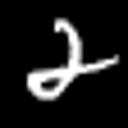
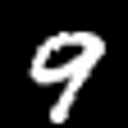
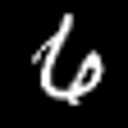
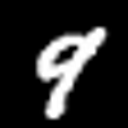
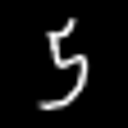
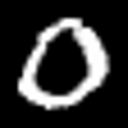
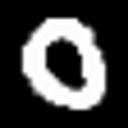
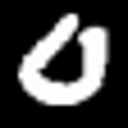
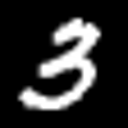
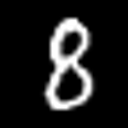
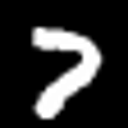
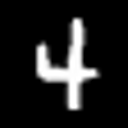
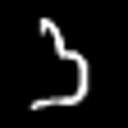
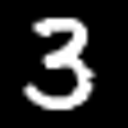
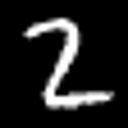
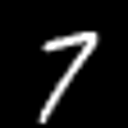

In [9]:
count = 8

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    image_datas = df.loc[image_ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[image_ids]['value']
    return images, list(labels)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [10]:
# COS_SIM_THRESHOLD = 0.075
COS_SIM_THRESHOLD = 0.055
hdc = Hdc(10_000, np)

In [11]:
class CorticalColumn(object):
    def __init__(self):
        self.clusters = defaultdict(list) # cluster = collection of image bundles for particular class
        self.cluster_norms = HdvArray(hdc.N, xp)
        self.cluster_to_image_ids = defaultdict(set)

In [15]:
COLUMN = CorticalColumn()
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

df_test_results = pd.DataFrame(columns=['source_ds', 'test_run_id', 'test_image_id', 'true_value', 'cluster_id', 'infer_value', 'sim'])

In [44]:
# TRAIN RUN
TRAIN_RUN_ID += 1
epochs = 10
attempts_to_get_no_mistakes = 20
count = 1000
consolidation_threshold = 1000

for epoch in tqdm(range(epochs), desc='Epoch'):
    train_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for attempt_to_get_no_mistakes in tqdm(range(attempts_to_get_no_mistakes), leave=False, desc='Attempt'):
        # EVOLVE MEMORIES
        for image_no, image_id in tqdm(enumerate(train_step_image_ids), leave=False, total=len(train_step_image_ids), desc='Image (train)'):
            log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Cluster count={COLUMN.cluster_norms.len()}')
            
            image_value = df_train_images.loc[image_id]['value']
            df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=train_db_con)
            assert len(df_image_encodings) > 0
            image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
            image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
            image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)
    
            cos_sim_matrix = COLUMN.cluster_norms.array @ image_encoding_hdvs_norm.T
            cos_sim_matrix[cos_sim_matrix < COS_SIM_THRESHOLD] = 0
            cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image
            
            assert cos_sim_vector.shape == (COLUMN.cluster_norms.array.shape[0],)
            cluster_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc
            match_found = False
            match_pos = False
            match_is_updated = False
    
            for pos, cluster_id in enumerate(cluster_ids_by_match_score):
                cos_sim_value = cos_sim_vector[cluster_id]
                log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Checking cluster #{cluster_id}, pos={pos}, sim={cos_sim_value:.2f}')
    
                if cos_sim_value <= 0:
                    break
    
                cluster_image_ids = COLUMN.cluster_to_image_ids[cluster_id]
                assert len(cluster_image_ids) > 0
                cluster_is_sealed = len(cluster_image_ids) > 200
                cluster_image_id = next(iter(cluster_image_ids))
                cluster_image_value = df_train_images.loc[cluster_image_id]['value']
    
                if cluster_image_value != image_value:
                    log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Match WRONG, cluster value={cluster_image_value} vs {image_value}')
                else:
                    log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Match CORRECT, sealed={cluster_is_sealed}')
    
                    if not cluster_is_sealed:
                        cluster_image_ids.add(image_id)
                        cluster_hdvs = COLUMN.clusters[cluster_id] # list
                        cluster_hdvs.append(hdc.bundle(image_encoding_hdvs))
                        new_cluster_bundle = xp_array_to_gpu(hdc.bundle(cluster_hdvs))
                        COLUMN.cluster_norms.array[cluster_id] = hdc.normalize(new_cluster_bundle)
    
                    match_found = True
                    match_pos = pos
                    match_is_updated = not cluster_is_sealed
                    break
    
            log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Match found={match_found}, pos={match_pos}, is updated={match_is_updated}')
    
            if (match_found and match_pos == 0) or (match_found and match_is_updated):
                pass
            else:
                cluster_id = COLUMN.cluster_norms.lease()
                cluster_bundle = hdc.bundle(image_encoding_hdvs)
                COLUMN.cluster_norms.array[cluster_id] = xp_array_to_gpu(hdc.normalize(cluster_bundle))
                COLUMN.clusters[cluster_id].append(cluster_bundle)
                COLUMN.cluster_to_image_ids[cluster_id].add(image_id)
                log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] New cluster {cluster_id}')
    
            if image_no > 0 and image_no % consolidation_threshold == 0:
                # CONSOLIDATE MEMORY
                def dump_cluster_lengths(when):
                    cluster_lengths = list(map(lambda image_ids: len(image_ids), COLUMN.cluster_to_image_ids.values()))
                    cluster_lengths = np.unique_counts(cluster_lengths)
                    
                    for v, c in zip(reversed(cluster_lengths.values), reversed(cluster_lengths.counts)):
                        log.debug(f'[train_run_id={TRAIN_RUN_ID}, consolidation] {when:10} {v:5} {c:5}')
    
                before_len = COLUMN.cluster_norms.len()
                assert before_len == len(COLUMN.clusters)
                
                log.debug(f'[train_run_id={TRAIN_RUN_ID}, consolidation] BEFORE clusters count = {before_len}')
                dump_cluster_lengths('BEFORE')
                
                cluster_indices_to_release = []
                
                for cluster_id, image_ids in COLUMN.cluster_to_image_ids.items():
                    #l = 0.1
                    l = 1
                    exp_distro_level = l * np.exp(-l * len(image_ids))
                    rand_level = RNG.random()
                    do_release = rand_level < exp_distro_level
                    
                    if do_release:
                        cluster_indices_to_release.append(cluster_id)
                        log.debug(f'[train_run_id={TRAIN_RUN_ID}, consolidation] Dropping cluster #{cluster_id}, len={len(image_ids)}: {rand_level:.5f} < {exp_distro_level:.5f}')
            
                for cluster_index_to_release in cluster_indices_to_release:
                    del COLUMN.clusters[cluster_index_to_release]
                    del COLUMN.cluster_to_image_ids[cluster_index_to_release]
                    COLUMN.cluster_norms.release(cluster_index_to_release)
            
                after_len = COLUMN.cluster_norms.len()
                assert after_len == len(COLUMN.clusters)
                
                log.debug(f'[train_run_id={TRAIN_RUN_ID}, consolidation] AFTER clusters count = {after_len}')
                dump_cluster_lengths('AFTER')

        mistake_image_ids = []
        
        for image_no, image_id in tqdm(enumerate(train_step_image_ids), leave=False, total=len(train_step_image_ids), desc='Image (test)'):
            image_value = df_train_images.loc[image_id]['value']
            df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=train_db_con)
            assert len(df_image_encodings) > 0
            image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
            image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
            image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)
        
            cos_sim_matrix = COLUMN.cluster_norms.array @ image_encoding_hdvs_norm.T
            cos_sim_matrix[cos_sim_matrix < COS_SIM_THRESHOLD] = 0
            cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image
            
            assert cos_sim_vector.shape == (COLUMN.cluster_norms.array.shape[0],)
            cluster_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc
        
            if cluster_ids_by_match_score.shape[0] > 0:
                cluster_id = cluster_ids_by_match_score[0]
                cos_sim_value = cos_sim_vector[cluster_id]
        
                if cos_sim_value > 0:
                    cluster_image_ids = COLUMN.cluster_to_image_ids[cluster_id]
                    assert len(cluster_image_ids) > 0
                    cluster_image_id = next(iter(cluster_image_ids))
                    cluster_image_value = df_train_images.loc[cluster_image_id]['value']

                    if cluster_image_value != image_value:
                        mistake_image_ids.append(image_id)

        log.debug(f'[train_run_id={TRAIN_RUN_ID}] Mistaken image ids = {len(mistake_image_ids)}')

        if not mistake_image_ids:
            break
            
        train_step_image_ids = mistake_image_ids

        

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Attempt:   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Attempt:   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Attempt:   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
len(COLUMN.clusters)

271


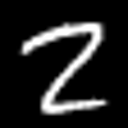
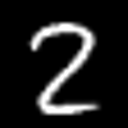
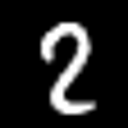
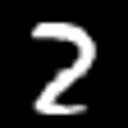
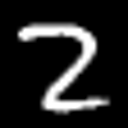
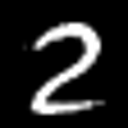
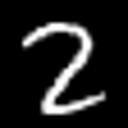
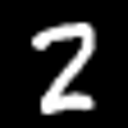
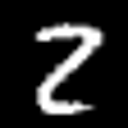

In [39]:
images = []
captions = []

if COLUMN.clusters.keys():
    random_cluster_i = RNG.choice(list(COLUMN.clusters.keys()))
    image_ids = COLUMN.cluster_to_image_ids[random_cluster_i]
    df_i = df_train_images.loc[list(image_ids)]
    image_datas = df_i['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    captions = list(map(lambda p: f'clust={random_cluster_i}, #{p[0]}, val={p[1]}', zip(df_i.index, df_i['value'])))

images = images[:32]
captions = captions[:32]
display_images_grid(images, captions=captions, col_count=8)

In [46]:
# TEST RUN
TEST_RUN_ID += 1
count = 2000
test_run_source = (df_test_images, test_db_con, 'test')
# test_run_source = (df_train_images, train_db_con, 'train')
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
test_result_rows = defaultdict(list)

for image_id in tqdm(test_image_ids):
    max_cos_sim_index = -1 # aka cluster id
    max_similar_cluster_image_value = ''
    max_cos_sim = 0

    image_value = test_run_source[0].loc[image_id]['value']
    df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=test_run_source[1])
    assert len(df_image_encodings) > 0
    image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
    image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
    image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)

    cos_sim_matrix = COLUMN.cluster_norms.array @ image_encoding_hdvs_norm.T
    cos_sim_matrix[cos_sim_matrix < COS_SIM_THRESHOLD] = 0
    cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image
    
    assert cos_sim_vector.shape == (COLUMN.cluster_norms.array.shape[0],)
    cluster_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc

    if cluster_ids_by_match_score.shape[0] > 0:
        cluster_id = cluster_ids_by_match_score[0]
        cos_sim_value = cos_sim_vector[cluster_id]

        # if cos_sim_value >= COS_SIM_THRESHOLD:
        if cos_sim_value > 0:
            cluster_image_ids = COLUMN.cluster_to_image_ids[cluster_id]
            assert len(cluster_image_ids) > 0
            cluster_image_id = next(iter(cluster_image_ids))
            cluster_image_value = df_train_images.loc[cluster_image_id]['value']
            max_cos_sim_index = cluster_id
            max_similar_cluster_image_value = cluster_image_value
            max_cos_sim = cos_sim_value
    
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['cluster_id'].append(max_cos_sim_index)
    test_result_rows['infer_value'].append(max_similar_cluster_image_value)
    test_result_rows['sim'].append(max_cos_sim)
    

assert set(test_result_rows.keys()) == set(df_test_results.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=df_test_results.columns)
concat_list = [df_test_results] if len(df_test_results) > 0 else []
concat_list.append(df_test_results_for_run)
df_test_results = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

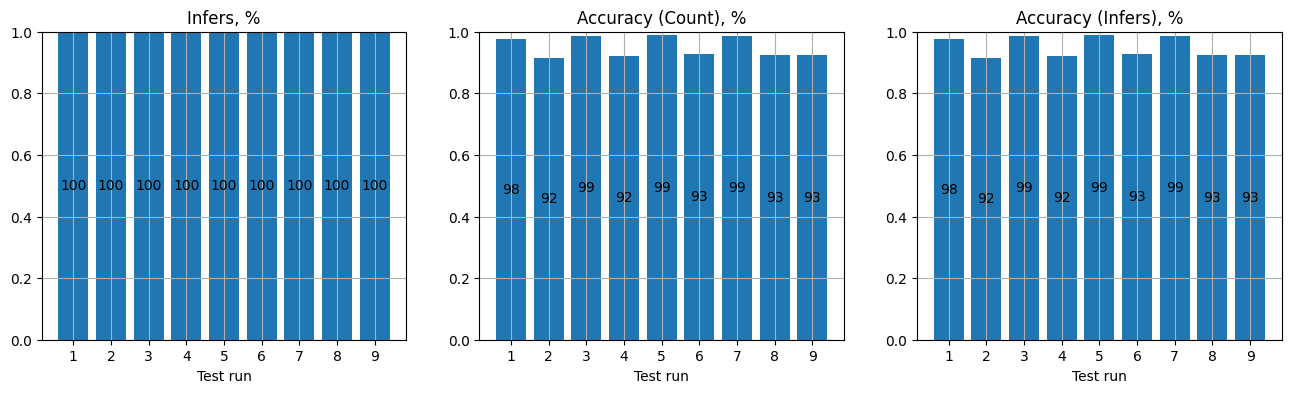

,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,
1,2000,2000,1950,1.0,0.9750,0.9750
2,2000,2000,1831,1.0,0.9155,0.9155
3,2000,2000,1973,1.0,0.9865,0.9865
4,2000,2000,1843,1.0,0.9215,0.9215
5,2000,2000,1977,1.0,0.9885,0.9885
6,2000,2000,1858,1.0,0.9290,0.9290
7,2000,2000,1975,1.0,0.9875,0.9875
8,2000,2000,1852,1.0,0.9260,0.9260
9,2000,2000,1852,1.0,0.9260,0.9260


In [47]:
df_test_results2 = df_test_results.copy()
df_test_results2['is_infer'] = df_test_results2['cluster_id'] > -1
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'test_image_id': 'count', 'is_infer': 'sum', 'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

In [80]:
df_test_results_incorrect_infers = df_test_results_for_run[df_test_results_for_run['true_value'] != df_test_results_for_run['infer_value']]
incorrect_infer_row_index = RNG.choice(df_test_results_incorrect_infers.index.unique())
test_run_id = df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['test_run_id']
incorrect_infer_image_id = df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['test_image_id']
image_data = test_run_source[0].loc[incorrect_infer_image_id]['png']
image_value = test_run_source[0].loc[incorrect_infer_image_id]['value']

df_x = pd.DataFrame(columns=['test_run_id', 'test_image_id', 'true_value', 'cluster_id', 'cluster_value', 'sim'])
df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(incorrect_infer_image_id)}, con=test_run_source[1])
assert len(df_image_encodings) > 0
image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)

cos_sim_matrix = COLUMN.cluster_norms.array @ image_encoding_hdvs_norm.T
cos_sim_matrix[cos_sim_matrix < COS_SIM_THRESHOLD] = 0
cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image

assert cos_sim_vector.shape == (COLUMN.cluster_norms.array.shape[0],)
cluster_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc

for pos, cluster_id in enumerate(cluster_ids_by_match_score):
    cos_sim_value = cos_sim_vector[cluster_id]

    if cos_sim_value <= 0:
        break
        
    cluster_image_ids = COLUMN.cluster_to_image_ids[cluster_id]
    assert len(cluster_image_ids) > 0
    cluster_image_id = next(iter(cluster_image_ids))
    cluster_image_value = df_train_images.loc[cluster_image_id]['value'] # exactly from train! (i.e. we look for prototype in train data)
    df_x.loc[len(df_x)] = [test_run_id, incorrect_infer_image_id, image_value, cluster_id, cluster_image_value, cos_sim_value]

df_x.sort_values(by='sim', ascending=False).head(10)

,test_run_id,test_image_id,true_value,cluster_id,cluster_value,sim
0,4,50714,8,7,3,4.746327
1,4,50714,8,25,5,4.530153
2,4,50714,8,116,3,4.209261
3,4,50714,8,2,0,4.037438
4,4,50714,8,235,8,3.949721
5,4,50714,8,6,5,3.851814
6,4,50714,8,374,3,3.809770
7,4,50714,8,324,3,3.416562
8,4,50714,8,60,0,3.321664
9,4,50714,8,68,8,3.160940



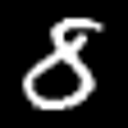

In [81]:
image_data = test_run_source[0].loc[incorrect_infer_image_id]['png']
image = Image.open(io.BytesIO(image_data))
label = test_run_source[0].loc[incorrect_infer_image_id]['value']
display_images([image], captions=[label])

In [59]:
df_x_pivot = pd.pivot_table(df_x, index='cluster_id', 
                            values=['true_value', 'cluster_value', 'sim'], 
                            aggfunc=dict(cluster_value='first', true_value='first', sim='sum'))
df_x_pivot.sort_values(by='sim', ascending=False)

,cluster_value,sim,true_value
cluster_id,,,
0,9,1.046799,9
249,7,1.044467,9
2,0,0.917181,9
226,9,0.548626,9
336,5,0.211032,9
192,5,0.12110580995225514,9
80,3,0.11793649906498342,9
104,3,0.10544239126778956,9
254,0,0.10111251713129436,9


In [60]:
df_x_pivot = pd.pivot_table(df_x, index='cluster_id', 
                            values=['true_value', 'cluster_value', 'sim'], 
                            aggfunc=dict(cluster_value='first', true_value='first', sim='max'))
df_x_pivot.sort_values(by='sim', ascending=False)

,cluster_value,sim,true_value
cluster_id,,,
0,9,0.13774479351577515,9
249,7,0.1341514822666483,9
2,0,0.13210493575102844,9
226,9,0.1267169300539585,9
192,5,0.12110580995225514,9
80,3,0.11793649906498342,9
336,5,0.10593183890130904,9
104,3,0.10544239126778956,9
254,0,0.10111251713129436,9


In [62]:
df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['test_run_id']

np.int64(4)

In [63]:
incorrect_infer_row_index

np.int64(1312)